In [ ]:
!pip install pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.9/800.9 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 31.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
import pytorch_lightning as pl
from torchvision import transforms
from sklearn.metrics import accuracy_score, classification_report, RocCurveDisplay

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_dir = '/content/drive/MyDrive/dataset/train/'
val_dir = '/content/drive/MyDrive/dataset/val/'

In [ ]:
transforms_to_apply = [
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomRotation([-90, +90])
]

In [ ]:
import os
train = []
print(os.listdir(train_dir))
for i, label in enumerate(['no', 'sphere', 'vort']):
  if label == ".DS_Store":
    continue
  for f in os.listdir(train_dir + label):
    for transform in transforms_to_apply:
      train.append((train_dir + label + "/" + f, i, transform))

['.DS_Store', 'sphere', 'vort', 'no']


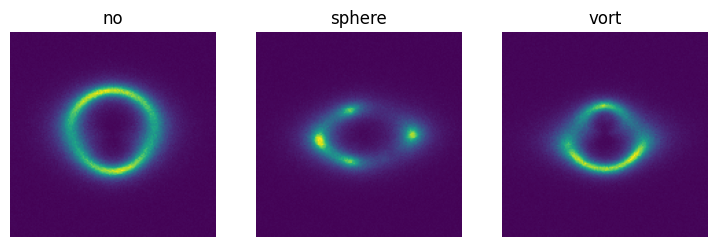

In [ ]:
plt.figure(figsize=(9, 3))
for i, label in enumerate(['no', 'sphere', 'vort']):
  plt.subplot(1, 3, i+1)
  plt.imshow(np.load(train[i*40000][0])[0])
  plt.title(label)
  plt.axis('off')

In [ ]:
val = []
print(os.listdir(val_dir))
for i, label in enumerate(['no', 'sphere', 'vort']):
  if label == '.DS_Store':
    continue
  for f in os.listdir(val_dir + label):
    val.append((val_dir + label + "/" + f, i))

['.DS_Store', 'vort', 'sphere', 'no']


In [ ]:
len(train)

120364

In [ ]:
class LensDataset(Dataset):
  def __init__(self, dataset):
    self.dataset = dataset

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    data = self.dataset[idx]
    return data[2](torch.Tensor(np.load(data[0])[:,40:120, 25:125])), data[1]

In [ ]:
class LensDatasetTest(Dataset):
  def __init__(self, dataset):
    self.dataset = dataset

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    data = self.dataset[idx]
    return torch.Tensor(np.load(data[0])[:, 40:120, 25:125]), data[1]

In [ ]:
class LensDataModule(pl.LightningDataModule):
    def __init__(
        self,
        train_data,
        test_data,
        batch_size = 16,
        dataloader_num_workers = 1,
    ) -> None:
        super().__init__()
        self.batch_size = batch_size
        self.dataloader_num_workers = dataloader_num_workers

        self.train_data = train_data
        self.test_data = test_data


    def train_dataloader(self):

        return DataLoader(
            LensDataset(self.train_data),
            batch_size=self.batch_size,
            shuffle=True,
            pin_memory=True,
            num_workers=self.dataloader_num_workers
        )

    def test_dataloader(self):
        return DataLoader(
            LensDatasetTest(self.test_data),
            batch_size=self.batch_size,
            shuffle=True,
            pin_memory=True,
            num_workers=self.dataloader_num_workers
        )

In [ ]:
class LensNet(pl.LightningModule):

  def __init__(self):
    super(LensNet, self).__init__()
    self.criterion = nn.CrossEntropyLoss()
    self.model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
    self.model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    self.model.fc = nn.LazyLinear(3)

  def forward(self, x):
    return self.model(x)

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=0.0003)
    return [optimizer]

  def training_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x)
    loss = self.criterion(y_hat, y)
    self.log("accuracy", accuracy_score(y.cpu().numpy(), torch.argmax(y_hat, dim=1).cpu().numpy()), prog_bar=True)
    return loss

  def test_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x)
    loss = self.criterion(y_hat, y)
    self.log("test_loss", loss)

  def predict_step(self, batch, batch_idx):
    x, y = batch
    pred = self(x)
    return pred, y

In [ ]:
data_module = LensDataModule(train, val)

In [ ]:
model = LensNet()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
trainer = pl.Trainer(max_epochs=20, accelerator="gpu", enable_progress_bar=True)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, data_module)

INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/model_summary/model_summary.py:454: A layer with UninitializedParameter was found. Thus, the total number of parameters detected may be inaccurate.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | model     | ResNet           | 11.2 M
-----------------------------------------------
11.2 M    Trainable params

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
preds_train = trainer.predict(model, data_module.train_dataloader())

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
pred_train = np.zeros((len(preds_train)*16, ))
y_train = np.zeros((len(preds_train)*16, ))

for i, value in enumerate(preds_train):
    try:
        pred_train[i*16:(i+1)*16] = torch.argmax(value[0], dim=1)
        y_train[i*16:(i+1)*16] = value[1]
    except:
        print(i)
        pred_train[i*16:i*16 + value[0].shape[0]] = torch.argmax(value[0], dim=1)
        y_train[i*16:i*16 + value[0].shape[0]] = value[1]

7522


In [ ]:
preds = trainer.predict(model, data_module.test_dataloader())

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
pred = np.zeros((len(preds)*16, ))
pred_proba = np.zeros((len(preds)*16, 3))
true = np.zeros((len(preds)*16, ))

for i, value in enumerate(preds):
    try:
        pred[i*16:(i+1)*16] = torch.argmax(value[0], dim=1)
        pred_proba[i*16:(i+1)*16] = F.softmax(value[0], dim=1)
        true[i*16:(i+1)*16] = value[1]
    except:
        print(i)
        pred[i*16:i*16 + value[0].shape[0]] = torch.argmax(value[0], dim=1)
        pred_proba[i*16:i*16 + value[0].shape[0]] = F.softmax(value[0], dim=1)
        true[i*16:i*16 + value[0].shape[0]] = value[1]

468


In [ ]:
print(classification_report(y_train, pred_train))

              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96     40004
         1.0       0.97      0.94      0.95     40280
         2.0       0.97      0.97      0.97     40084

    accuracy                           0.96    120368
   macro avg       0.96      0.96      0.96    120368
weighted avg       0.96      0.96      0.96    120368



In [ ]:
print(classification_report(true, pred))

              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95      2504
         1.0       0.94      0.91      0.93      2500
         2.0       0.94      0.97      0.96      2500

    accuracy                           0.94      7504
   macro avg       0.94      0.94      0.94      7504
weighted avg       0.94      0.94      0.94      7504



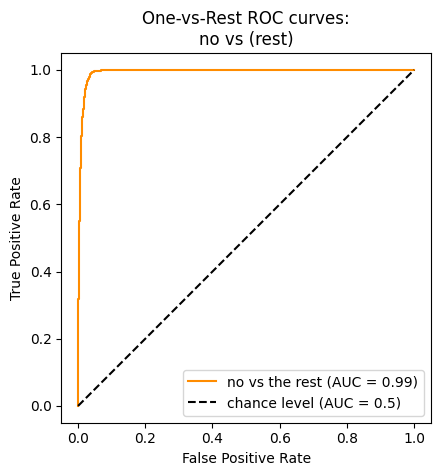

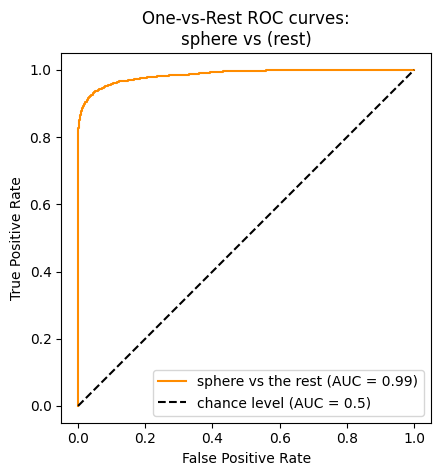

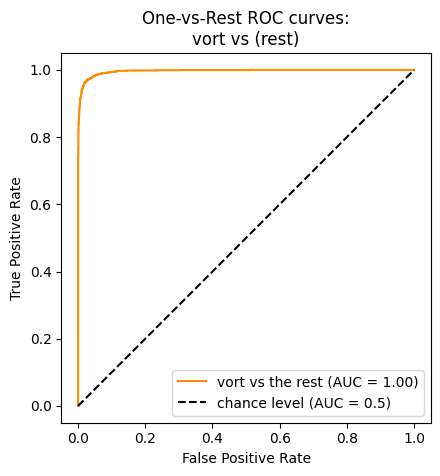

In [ ]:
for i, label in enumerate(['no', 'sphere', 'vort']):

    display = RocCurveDisplay.from_predictions(
        (true == i),
        pred_proba[:,i],
        name=f"{label} vs the rest",
        color="darkorange",
    )
    plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"One-vs-Rest ROC curves:\n{label} vs (rest)")
    plt.legend()